<a href="https://colab.research.google.com/github/mimsad/Bangla_Image_Captioning/blob/main/Bangla_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
from string import punctuation as punc
from glob import glob

import nltk
from PIL import Image
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

#### Command for downloading the ImageFile
Link : https://data.mendeley.com/datasets/rxxch9vw59/2

In [ ]:
#!curl "https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/6312cfc2-6930-4530-9589-105499b29d5e" --output "/content/images.zip"

In [ ]:
!7z x "/content/drive/My Drive/ImageCaption/images.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/ImageCaption/                                               1 file, 6758950318 bytes (6446 MiB)

Extracting archive: /content/drive/My Drive/ImageCaption/images.zip
  2% 256 Open               5% 512 Open               8% 768 Open              11% 1024 Open               13% 1280 Open               16% 1536 Open               19% 1792 Open               22% 2048 Open               25% 2304 Open            

#### Reading JSON file to extract the captions

In [ ]:
# punctuation remover
# chr(2404) : bengali full-stop unicode
punc_table = str.maketrans('', '', punc+chr(2404))

with open("/content/drive/My Drive/ImageCaption/captions.json", mode='rb') as f:
    caption_data = json.load(f)

caps = {}
for cap in caption_data:
    tmp = []
    for sentence in cap['caption']:
        # Removing spaces from front and back
        tstr = sentence.strip()
        # Removing extra spaces from middle
        tstr = ' '.join(tstr.split())
        tstr = tstr.translate(punc_table)

        tmp.append('startseq ' + tstr + ' endseq')
    
    caps[cap['filename'].split('.')[0]] = tmp

An example of the RAW JSON data

In [ ]:
for a in caption_data[:2]:
    print(a)

{'filename': '1.png', 'caption': ['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।', 'একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। ']}
{'filename': '2.png', 'caption': ['অনেক মেয়ে মানুষ বসে আছে।', 'একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে  তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা। ']}


What it looks like after being converted

In [ ]:
print(caps['1'])
print(caps['2'])

['startseq তিন জন মেয়ে মানুষ আছে এক জন দাড়িয়ে আছে আর দুই জন বসে আছে endseq', 'startseq একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে endseq']
['startseq অনেক মেয়ে মানুষ বসে আছে endseq', 'startseq একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা endseq']


Fetching image paths

In [ ]:
image_dirs = glob("/content/images/**")
print(len(image_dirs), "images found")

9154 images found


Example of three image paths

In [ ]:
print(image_dirs[:3])

['/content/images/8282.png', '/content/images/6096.png', '/content/images/8861.png']


In [ ]:
imgs = {}

# Remove the [:5]
for img_dir in tqdm(image_dirs):
    img = Image.open(img_dir).resize((299, 299))
    img = np.array(img)

    img_idx = img_dir.split('/')[-1]
    img_idx = img_idx.split('.')[0]
    imgs[img_idx] = img

#### imgs : image dictionary
#### caps : caption dictionary

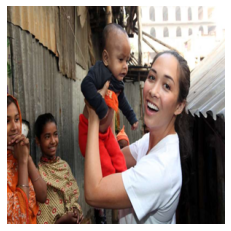

Captions:
startseq একজন নারী একটি শিশু কোলে নিয়ে আছে পাশে দুইজন নারী আছে endseq
startseq একজন বিদেশি মহিলা একজন বাচ্চাকে কুলে নিয়ে ধরে আছে এবং পাশ থেকে দেখছে ২ জন ছোট মেয়ে endseq


In [ ]:
idx = '1909'
plt.imshow(imgs[idx])
plt.axis(False)
plt.show()

print('Captions:')
for cap in caps[idx]:
    print(cap)

In [ ]:
word_count = {}

for sentences in caps.values():
    for sentence in sentences:
        for word in sentence.split():
            if word not in word_count:
                word_count[word] = 0
            word_count[word] += 1

In [ ]:
print(len(word_count), 'unique words')

5189 unique words


In [ ]:
vocab = set(word for word, cnt in word_count.items() if cnt >= 5)
print(len(vocab), 'unique words after filter')

1515 unique words after filter


In [ ]:
print(vocab)

{'ঝালায়ের', 'আনেক', 'ভিতর', 'সিগারেট', 'অব', 'ঘোমটা', 'সূর্য', '১', 'বড়', 'টাঙানো', 'মহিলাকে', 'আকাশে', 'চারা', 'মঞ্চের', 'ঝর্ণা', 'আঁশ', 'কালো', 'অন', 'দিকে', 'হাঁড়িপাতিল', 'ধরে', 'অ', 'কচুরিপানা', 'ভাসছে', 'লোককে', 'চলাফেরা', 'স্পীড', 'দড়ি', 'হা', 'ছেলের', 'পুকুরে', 'মারছে', 'হিজরা', 'চাকা', 'বৃষ্টির', 'খেলনার', 'কয়েকটা', 'কাটছেন', 'ড্রেস', 'কর্মকর্তা', 'সবজি', 'নিচে', 'ঢেকে', 'ঘাস', 'ওড়না', 'সময়', 'খালের', 'মাঝ', 'তার', 'বেশিরভাগ', 'ইট', 'জানালার', 'খানে', 'লালসাদা', 'টানছেন', 'দেখাচ্ছেন', 'কাঁদে', 'খেলতে', 'খাতা', 'বালতিতে', 'মন্দিরের', 'বাচ্চাকে', 'বুক', 'মানুষজন', 'তরমুজ', 'ঘোড়ায়', 'চায়ের', 'একটু', 'আকাশী', 'হাঁটছেন', 'জ্বেলে', 'দুইতলা', 'বামপাশের', 'নানান', 'খাচ্ছে', 'দুইটা', 'ছেলেরা', 'কাঁচি', 'রিক্সার', 'ফুলের', 'মাছ', 'লিখছে', 'পাটের', 'নামাজ', 'তুলে', 'সান', 'কাগজের', 'হাতির', 'কলা', 'বালির', 'কোরআন', 'উপহার', 'ভাষা', 'ক্রেস্ট', 'উপরের', 'বক্তৃতা', 'জড়ো', 'কলে', 'সকালে', 'আশে', 'টেবিলের', 'পুলিশ', 'আকাশ', 'লুঙ্গি', 'সারিতে', 'বসিয়ে', 'ছয়টি', 'পাঁচটি', 'মন্দির', 'ম্যাক্সি', '

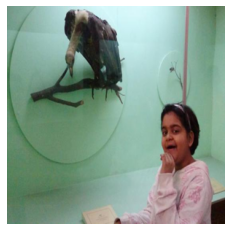

Actual Caption: startseq একজন বালিকা মুখে হাত দিয়ে তাকিয়ে আছে endseq
Filtered Caption: startseq একজন বালিকা মুখে হাত দিয়ে তাকিয়ে আছে endseq


In [ ]:
idx = '402'
plt.imshow(imgs[idx])
plt.axis(False)
plt.show()

id = 0

print('Actual Caption:', caps[idx][id])
cap = [x for x in (caps[idx][id]).split() if x in vocab]
print('Filtered Caption:', ' '.join(cap))

In [ ]:
new_caps = {}
max_len = 0

for key, values in caps.items():
    tmp = []
    
    for value in values:
        fvalue = [x for x in value.split() if x in vocab]
        if len(fvalue) >= 2:
            tmp.append(' '.join(fvalue))
            max_len = max(max_len, len(fvalue))
    
    if len(tmp) > 0:
        new_caps[key] = tmp

print(max_len)

39


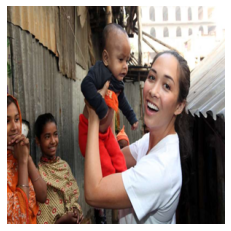

Captions:
startseq একজন নারী একটি শিশু কোলে নিয়ে আছে পাশে দুইজন নারী আছে endseq
startseq একজন বিদেশি মহিলা একজন বাচ্চাকে কুলে নিয়ে ধরে আছে এবং পাশ থেকে দেখছে ২ জন ছোট মেয়ে endseq


In [ ]:
idx = '1909'
plt.imshow(imgs[idx])
plt.axis(False)
plt.show()
print('Captions:')
for cap in new_caps[idx]:
    print(cap)

In [ ]:
word_to_id = {}
id_to_word = {}

id = 1
for word in vocab:
    word_to_id[word] = id
    id_to_word[id] = word
    id += 1

In [ ]:
vocab_size = len(vocab) + 1
embedding_dim = 100
max_len = 39

In [ ]:
# Reading Glove embedding

glove_path = "/content/drive/My Drive/ImageCaption/bn_glove.100d.txt"
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embd_cnt = 0

with open(glove_path, mode='r', encoding="utf-8") as f:
    for line in tqdm(f.readlines()):
        chunks = line.split()
        word, embedding = chunks[0], chunks[1:]

        if word in vocab:
            id = word_to_id.get(word)
            embedding_matrix[id] = embedding
            embd_cnt += 1

print(embd_cnt, 'embeddings found')


1169 embeddings found


In [ ]:
model = tf.keras.applications.Xception(input_shape=(299, 299, 3),
                                       include_top=True)

model = tf.keras.Model(model.input, model.layers[-2].output)
#model.summary()

91889664/91884032 [==============================] - 0s 0us/step


In [ ]:
cimgs = {}

for key, img in tqdm(imgs.items()):
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.xception.preprocess_input(img)
    tmp = model(img)
    cimgs[key] = np.reshape(tmp, (2048))
    #print(tmp.shape)

In [ ]:
# Saving processed data for future use
import pickle
save_path = "/content/drive/My Drive/ImageCaption/executed"

def save_variables(vars, base_dir):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    for var in vars:
        with open(os.path.join(base_dir, (var+'.pkl')), 'wb') as f:
            pickle.dump(eval(var), f)


def load_variables(vars, base_dir):
    if not os.path.exists(base_dir):
        print('Invalid path')
        return

    rets = {}
    for var in vars:
        with open(os.path.join(base_dir, (var+'.pkl')), 'rb') as f:
            rets[var] = pickle.load(f)
    return list(rets.values())

In [ ]:
#save_variables(['word_to_id', 
#                'id_to_word', 
#                'cimgs', 
#                'embedding_matrix',
#                'new_caps'],
#               save_path)

In [ ]:
word_to_id, id_to_word, cimgs, embedding_matrix, \
new_caps = load_variables(['word_to_id', 
                           'id_to_word', 
                           'cimgs', 
                           'embedding_matrix',
                           'new_caps'],
                          save_path)

vocab_size, embedding_dim = embedding_matrix.shape
max_len = 39

In [ ]:
def caption_model(input_shape, embedding_dim, vocab_size,
                  embedding_matrix, trainable=True):
    # Image embedding input
    input1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(input1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Word embedding input
    input2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(input2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # Merging the inputs
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    cmodel = tf.keras.Model(inputs=[input1, input2], outputs=outputs)
    
    cmodel.compile(loss='categorical_crossentropy', optimizer='adam')

    cmodel.layers[2].set_weights([embedding_matrix])
    cmodel.layers[2].trainable = trainable

    return cmodel

In [ ]:
cmodel = caption_model((2048,), embedding_dim, vocab_size,
                       embedding_matrix)

In [ ]:
class dataGenerator(tf.keras.utils.Sequence):
    """ Recieves X and y 
        Performes pairwise matching with a batch size 
        both pairs are generated from the input X and y
    """
    def __init__(self, img_emb, captions, word_to_id, batch_size=12):
        self.imgs        = img_emb 
        self.caps        = captions
        self.batch_size  = batch_size
        self.word_to_id  = word_to_id
        self.keys        = list(self.imgs.keys())
        self.total       = len(self.keys)
        self.on_epoch_end()

    def __len__(self):
        """ Denotes the number of batches per epoch """
        return int(self.total // self.batch_size)

    def __getitem__(self, index):
        """ Generate one batch of data """
        batch_keys = self.keys[index*self.batch_size:(index+1)*self.batch_size]
        X1, X2, y = [], [], []
        
        #print(len(batch_keys))

        for key in batch_keys:
            id = random.randint(0, len(self.caps[key])-1)
            cap_id = [word_to_id[word] for word in self.caps[key][id].split()]

            for i in range(1, len(cap_id)):
                inp_seq, out_seq = cap_id[:i], cap_id[i]
                
                inp_seq = pad_sequences([inp_seq], maxlen=max_len)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                X1.append(self.imgs[key])
                X2.append(inp_seq)
                y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        choices = random.sample(range(0, X1.shape[0]), self.batch_size*4)

        return [X1[choices], X2[choices]], y[choices]
        

    def on_epoch_end(self):
        """ Updates indexes after each epoch """
        np.random.shuffle(self.keys)

In [ ]:
train_index, test_index = train_test_split(list(cimgs.keys()), 
                                           test_size=0.20,
                                           random_state=42)

In [ ]:
train_cimgs = {key:cimgs.get(key) for key in train_index}
test_cimgs  = {key:cimgs.get(key) for key in test_index}

In [ ]:
batch_size = 256

train_gen = dataGenerator(train_cimgs, new_caps, word_to_id, 
                          batch_size=batch_size//4)
test_gen  = dataGenerator(test_cimgs, new_caps, word_to_id, 
                          batch_size=batch_size//4)

[a, b], c = train_gen[0]
print(a.shape, c.shape)

(256, 2048) (256, 1516)


In [ ]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=10, 
                                             verbose=1, 
                                             restore_best_weights=True),
             
            tf.keras.callbacks.ModelCheckpoint(os.path.join(save_path, 'model'), 
                                               monitor="val_loss",
                                               save_weights_only=False,
                                               mode='min',
                                               save_best_only=True),
        ]

In [ ]:
his = cmodel.fit(train_gen, validation_data=test_gen,
                 epochs=200, callbacks=callbacks)

In [ ]:
cmodel = tf.keras.models.load_model("/content/drive/My Drive/ImageCaption/executed/model")

In [ ]:
def greedySearch(photo_embedding):
    in_text = 'startseq'
    photo_embedding = np.expand_dims(photo_embedding, axis=0)

    for i in range(max_len):
        sequence = [word_to_id[w] for w in in_text.split() if w in word_to_id]
        sequence = pad_sequences([sequence], maxlen=max_len)

        yhat = cmodel.predict([photo_embedding, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = id_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

For more information on BLEU, see [this](https://stackoverflow.com/questions/32395880/calculate-bleu-score-in-python/39062009)

Predicted
 জমির উপর দিয়ে হেটে যাচ্ছেন একজন পুরুষ এবং দূরে কিছু গাছ
Ans
অনেকগুলো পুরুষ হেঁটে যাচ্ছে দূরে পাহাড় আছে
চারদিকে সবুজ গাছপালা আর তার মাঝে সবুজ ক্ষেতের পথ ধরে কয়েকজন লোক হেঁটে যাচ্ছে
0.505469194721007


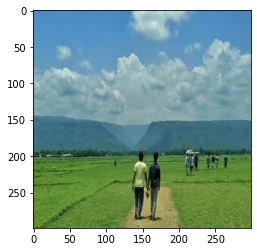

In [ ]:
imgid = list(test_cimgs.keys())[0]

plt.imshow(imgs[imgid])
plt.grid(False)

pred = greedySearch(test_cimgs[imgid])
ans = []

print("Predicted\n", pred)
print("Ans")
for c in new_caps[imgid]:
    cc = " ".join(c.split()[1:-1])
    ans.append(cc)
    print(cc)

BLEUscore = nltk.translate.bleu_score.sentence_bleu(ans, pred)
print(BLEUscore)

In [ ]:
scores = []

for imgid in tqdm(test_cimgs.keys()):
    pred = greedySearch(test_cimgs[imgid])
    ans = []

    for c in new_caps[imgid]:
        cc = " ".join(c.split()[1:-1])
        ans.append(cc)
        #print(cc)

    BLEUscore = nltk.translate.bleu_score.sentence_bleu(ans, pred)
    scores.append(BLEUscore)

In [ ]:
print(sum(scores)/len(scores))

0.4256267487102424

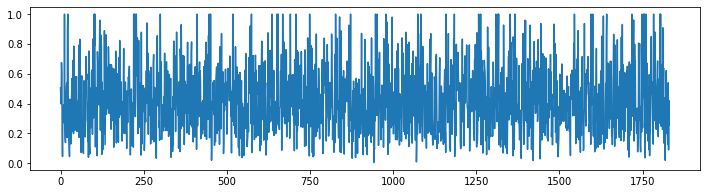

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(scores)), scores)